In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import random
import torch.nn.functional as F

device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Data understanding layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        # Task understanding
        self.task_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)
        # Infer task embedding
        z = self.task_head(features)
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, input_dim_per_point, num_points_per_sample, output_dim_per_point):
        super().__init__()
        input_size = latent_dim + (num_points_per_sample * input_dim_per_point)
        
        # Shared layers
        self.shared = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        # Task-specific heads
        self.regression_head = nn.Linear(256, num_points_per_sample)
        self.classification_head = nn.Linear(256, num_points_per_sample)
        
        self.num_points_per_sample = num_points_per_sample
        self.output_dim_per_point = output_dim_per_point

    def forward(self, z, y):
        batch_size = y.size(0)
        y_flat = y.view(batch_size, -1)
        x = torch.cat([z, y_flat], dim=1)
        
        # Shared features
        features = self.shared(x)
        
        # Task-specific outputs
        reg_out = self.regression_head(features)
        class_out = self.classification_head(features)
        
        # Combine outputs based on learned patterns
        gate = torch.sigmoid(z[:, 0]).unsqueeze(1)  # Use first latent dim as task indicator
        out = gate * reg_out + (1 - gate) * class_out
        
        return out.view(-1, self.num_points_per_sample, self.output_dim_per_point)



In [3]:
# Modified Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, num_points_per_sample, input_dim_per_point, output_dim_per_point):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim_per_point, num_points_per_sample, output_dim_per_point)
    
    def forward(self, x, sample_data, task):
        z = self.encoder(x)
        y_out = self.decoder(z, sample_data)
        return y_out

In [4]:
# Define Tasks
tasks = {
    "classify_boundary": {"input_dim": 2, "output_dim": 1},
    "add_numbers": {"input_dim": 2, "output_dim": 1},
    "subtract_numbers": {"input_dim": 2, "output_dim": 1}
    #"multiclass_boundary": {"input_dim": 2, "output_dim": 1}
}

In [5]:
# Dataset
class TaskDataset(Dataset):
    def __init__(self, task, num_samples=1000, num_points_per_sample=100):
        self.task = task
        self.num_samples = num_samples
        self.num_points_per_sample = num_points_per_sample
        self.offset = torch.randint(0, 5, (1,)).item()
        self.data, self.labels = self.generate_data(task, num_samples, num_points_per_sample)
    
    def generate_data(self, task, num_samples, num_points_per_sample):
        data = []
        labels = []
        for _ in range(num_samples):
            if task == "classify_boundary":
                x = torch.randint(-10, 10, (num_points_per_sample, 2)).float()
                y = (x[:, 0] + x[:, 1] > self.offset).float().unsqueeze(1)
            elif task == "add_numbers":
                a = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                b = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                x = torch.cat([a, b], dim=1)
                y = a + b + self.offset
            elif task == "subtract_numbers":
                a = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                b = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                x = torch.cat([a, b], dim=1)
                y = a - b + self.offset
            elif task == "multiclass_boundary":
                x = torch.randint(-10, 10, (num_points_per_sample, 2)).float()
                y = torch.zeros(num_points_per_sample, 1)
                y[(x[:, 0] + x[:, 1] > self.offset), 0] = 1
                y[(x[:, 0] - x[:, 1] > self.offset), 0] += 1
            data.append(x)
            labels.append(y)
        return data, labels
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        # Flatten x and y
        x_flat = x.view(-1)
        y_flat = y.view(-1)
        xy = torch.cat((x_flat, y_flat), dim=0)
        return xy
    
    def get_offset(self):
        return self.offset


In [6]:
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize Model
num_points_per_sample = 200
input_dim_per_point = 2
output_dim_per_point = 1
input_dim = num_points_per_sample * (input_dim_per_point + output_dim_per_point)
latent_dim = 20

model = Autoencoder(
    input_dim=input_dim,
    latent_dim=latent_dim,
    num_points_per_sample=num_points_per_sample,
    input_dim_per_point=input_dim_per_point,
    output_dim_per_point=output_dim_per_point
).to(device)

# Initialize optimizers with learning rate scheduling
optimizers = {
    'classify_boundary': optim.Adam(model.parameters(), lr=1e-4),
    'add_numbers': optim.Adam(model.parameters(), lr=1e-2),
    'subtract_numbers': optim.Adam(model.parameters(), lr=1e-2)
}


model = model.to(device)  # Move model to GPU

epochs = 15
batch_size = 128
loss = 0

In [7]:
# Modified training loop
class EMALossTracker:
    def __init__(self, alpha=0.99):
        self.ema_losses = {}
        self.alpha = alpha
    
    def update(self, task, loss):
        if task not in self.ema_losses:
            self.ema_losses[task] = loss
        else:
            self.ema_losses[task] = self.alpha * self.ema_losses[task] + (1-self.alpha) * loss
        return self.ema_losses[task]

loss_tracker = EMALossTracker()

def get_task_sequence(iteration, total_iterations=15):
    if iteration < 7:
        # First 7 iterations alternate between add and subtract
        return 'add_numbers' if iteration % 2 == 0 else 'subtract_numbers'
    elif iteration < 12:
        # Next 5 iterations are classification
        return 'classify_boundary'
    else:
        # Last 3 iterations alternate between add and subtract
        return 'add_numbers' if iteration % 2 == 0 else 'subtract_numbers'

In [8]:
# Initialize loss tracking
task_losses = {
    'classify_boundary': {'instant': [], 'running': []},
    'add_numbers': {'instant': [], 'running': []},
    'subtract_numbers': {'instant': [], 'running': []}
}

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()
    task = get_task_sequence(epoch)
    for _ in range(100):
        dataset = TaskDataset(task, num_samples=(batch_size * 10), num_points_per_sample=num_points_per_sample)
        valadation = TaskDataset(task, num_samples=(batch_size * 10), num_points_per_sample=num_points_per_sample)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(valadation, batch_size=batch_size, shuffle=True)
        
        for xy in loader:
            for valxy in valloader:
                break
            
            xy = xy.to(device)
            valxy = valxy.to(device)
            x_size = input_dim_per_point * num_points_per_sample
            
            x = valxy[:, :x_size].view(-1, num_points_per_sample, input_dim_per_point).to(device)
            y = valxy[:, x_size:].view(-1, num_points_per_sample, output_dim_per_point).to(device)
            
            optimizers[task].zero_grad()
            y_pred = model(xy, x, task)
            
            if task == "classify_boundary":
                y_pred = torch.sigmoid(y_pred)
                y = y.float()
                loss = F.binary_cross_entropy(y_pred, y)
                running_loss = loss_tracker.update(task, loss.item())
            else:
                loss = F.mse_loss(y_pred, y)
                running_loss = loss_tracker.update(task, loss.item())
            
            
            # In training loop:
            loss.backward()
            optimizers[task].step()
            # Store losses
            task_losses[task]['instant'].append(loss.item())
            task_losses[task]['running'].append(running_loss)
            
    print(f"Task: {task}, Loss: {loss.item():.4f}, Running Loss: {running_loss:.4f}")

# Save losses for plotting
torch.save(task_losses, 'task_losses.pt')

Epoch 1/15
Task: add_numbers, Loss: 265.8143, Running Loss: 386.8019
Epoch 2/15
Task: subtract_numbers, Loss: 97.3185, Running Loss: 101.9564
Epoch 3/15
Task: add_numbers, Loss: 55.8806, Running Loss: 62.0362
Epoch 4/15
Task: subtract_numbers, Loss: 48.6202, Running Loss: 51.1848
Epoch 5/15
Task: add_numbers, Loss: 51.2473, Running Loss: 48.5868
Epoch 6/15
Task: subtract_numbers, Loss: 41.2490, Running Loss: 46.2980
Epoch 7/15
Task: add_numbers, Loss: 57.2026, Running Loss: 51.0560
Epoch 8/15
Task: classify_boundary, Loss: 0.9687, Running Loss: 8.9891
Epoch 9/15
Task: classify_boundary, Loss: 0.1961, Running Loss: 0.4138
Epoch 10/15
Task: classify_boundary, Loss: 0.1627, Running Loss: 0.3334
Epoch 11/15
Task: classify_boundary, Loss: 0.2032, Running Loss: 0.4665
Epoch 12/15
Task: classify_boundary, Loss: 0.2432, Running Loss: 0.3111
Epoch 13/15
Task: add_numbers, Loss: 41.6467, Running Loss: 49.3227
Epoch 14/15
Task: subtract_numbers, Loss: 40.2267, Running Loss: 46.5808
Epoch 15/15
Ta

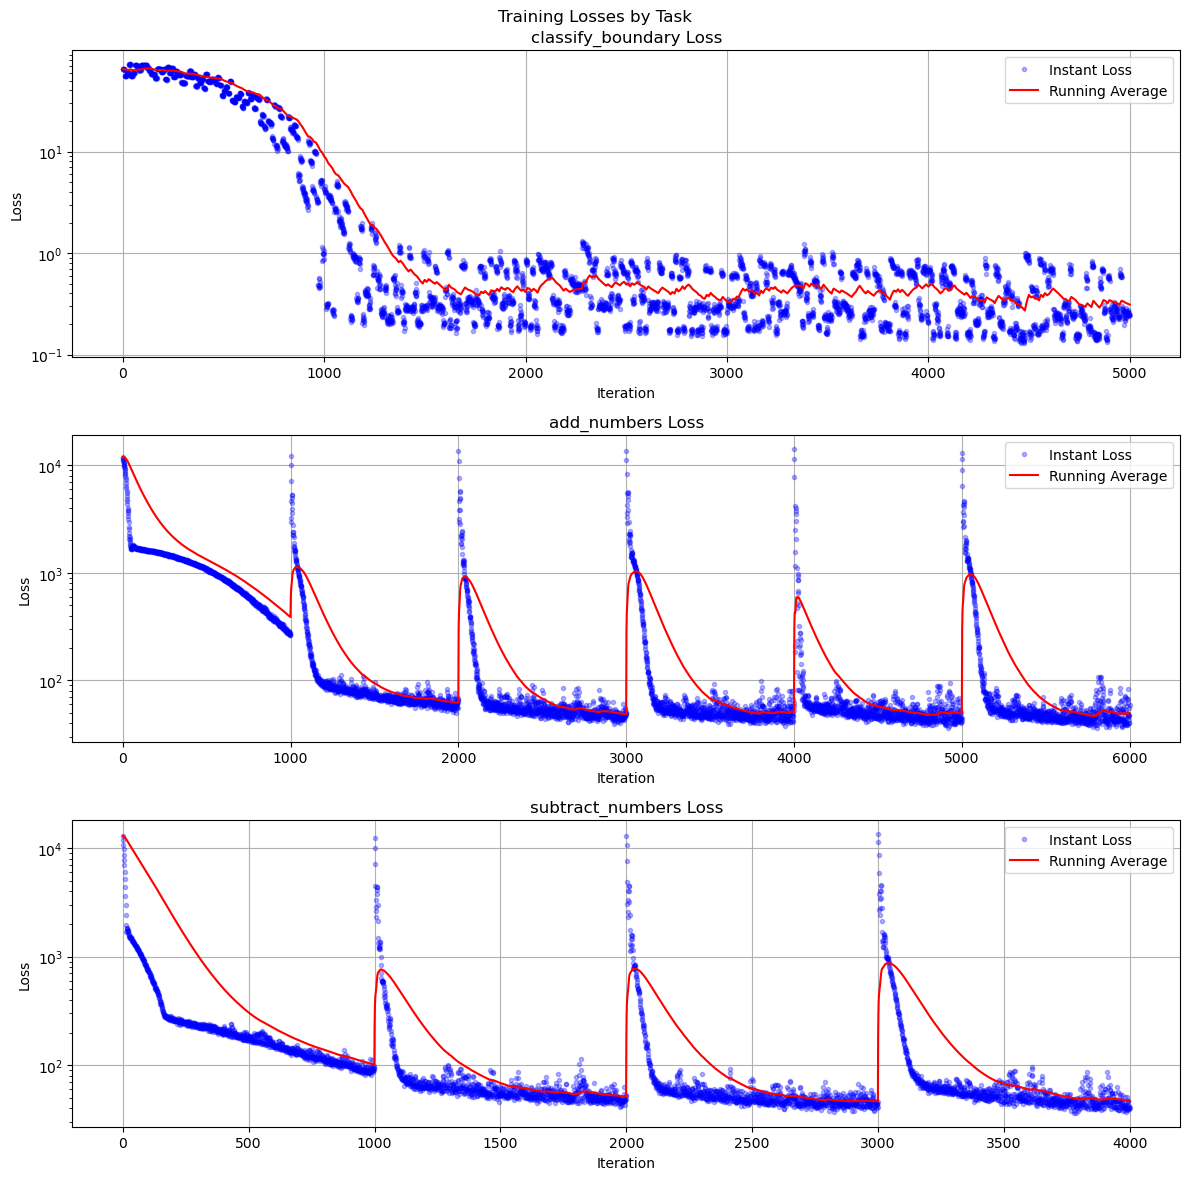

In [9]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Training Losses by Task')

# Plot each task
for idx, (task, losses) in enumerate(task_losses.items()):
    ax = axes[idx]
    
    # Plot instant losses
    ax.plot(losses['instant'], 'b.', alpha=0.3, label='Instant Loss')
    
    # Plot running average
    ax.plot(losses['running'], 'r-', label='Running Average')
    
    ax.set_title(f'{task} Loss')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

In [12]:
torch.save(model.encoder.state_dict(), 'encoder_weights.pth')

In [10]:
def print_predictions(y_pred, y, num_samples=5):
    # Select first few samples
    y_pred_sample = y_pred[:num_samples].detach().cpu()
    y_true_sample = y[:num_samples].detach().cpu()
    
    # Concatenate predictions and ground truth
    comparison = torch.cat([y_pred_sample, y_true_sample], dim=2)
    
    print("\nPredictions vs Ground Truth (first 5 samples):")
    print("Format: [prediction | true value]")
    print("-" * 50)
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(comparison[i])
        print()

# Use in training loop


In [11]:
def test_model(model, device, num_samples=1000):
    """Test model accuracy on each task"""
    model.eval()
    results = {}
    
    with torch.no_grad():
        for task in tasks.keys():
            # Generate test data
            test_dataset = TaskDataset(task, num_samples=num_samples, 
                                     num_points_per_sample=num_points_per_sample)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            
            correct = 0
            total = 0
            
            for xy in test_loader:
                xy = xy.to(device)
                
                # Split into x and y components
                x_size = num_points_per_sample * input_dim_per_point
                x = xy[:, :x_size].view(-1, num_points_per_sample, input_dim_per_point)
                y = xy[:, x_size:].view(-1, num_points_per_sample, output_dim_per_point)
                
                # Get predictions
                y_pred = model(xy, x, task)
                
                if task == "classify_boundary":
                    y_pred = torch.sigmoid(y_pred)
                    predictions = (y_pred > 0.5).float()
                    correct += (predictions == y).sum().item()
                    total += y.numel()
                
                if task == "add_numbers" or task == "subtract_numbers":
                    print_predictions(y_pred, y)
                    correct += ((y_pred - y).abs() < 5).sum().item()
                    total += y.numel()
                
                if task == "multiclass_boundary":
                    _, predicted = torch.max(y_pred, 1)
                    correct += (predicted == y).sum().item()
                    total += y.numel()
                
                # Add other task types here as elif statements
                
            accuracy = (correct / total) * 100
            results[task] = accuracy
            print(f"{task} Accuracy: {accuracy:.2f}%")
    
    return results

# Example usage:
test_results = test_model(model, device)

classify_boundary Accuracy: 39.94%

Predictions vs Ground Truth (first 5 samples):
Format: [prediction | true value]
--------------------------------------------------
Sample 1:
tensor([[ 78.9022,  90.0000],
        [138.2372, 144.0000],
        [149.1877, 154.0000],
        [ 79.6790,  82.0000],
        [168.8589, 172.0000],
        [127.8941, 140.0000],
        [178.0289, 186.0000],
        [142.2158, 160.0000],
        [142.5890, 143.0000],
        [106.6143, 112.0000],
        [103.8805, 107.0000],
        [ 71.2767,  82.0000],
        [167.4677, 176.0000],
        [ 60.7793,  59.0000],
        [124.4003, 135.0000],
        [148.4071, 153.0000],
        [ 27.9814,  34.0000],
        [ 42.2443,  48.0000],
        [167.6273, 167.0000],
        [ 32.6952,  28.0000],
        [ 71.3047,  76.0000],
        [ 86.6645,  91.0000],
        [ 49.6946,  46.0000],
        [168.7042, 180.0000],
        [139.4305, 152.0000],
        [110.4786, 116.0000],
        [ 85.0965,  92.0000],
        [ 88